In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ninehub","key":"684562608813aaa7d966bfb067a78b85"}'}

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d itachi9604/disease-symptom-description-dataset
!unzip disease-symptom-description-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/30.1k [00:00<?, ?B/s]
100% 30.1k/30.1k [00:00<00:00, 41.3MB/s]
Archive:  disease-symptom-description-dataset.zip
  inflating: Symptom-severity.csv    
  inflating: dataset.csv             
  inflating: symptom_Description.csv  
  inflating: symptom_precaution.csv  


In [ ]:
import requests
import pandas as pd
import json

def fetch_fda_events(limit=1000):
    all_results = []
    skip = 0
    while len(all_results) < limit:
        print(f"Fetching records {skip} to {skip+100}...")
        r = requests.get(
            "https://api.fda.gov/drug/event.json",
            params={"limit": 100, "skip": skip}
        )
        if r.status_code != 200:
            print("Erreur API:", r.status_code)
            break
        batch = r.json().get("results", [])
        all_results.extend(batch)
        skip += 100
    return all_results

# Collecte de 1000 événements (modifiable)
events_data = fetch_fda_events(limit=1000)

# Sauvegarde au format JSON
with open("openfda_events.json", "w") as f:
    json.dump(events_data, f, indent=2)

print("✅ Données FDA sauvegardées dans openfda_events.json")


Fetching records 0 to 100...
Fetching records 100 to 200...
Fetching records 200 to 300...
Fetching records 300 to 400...
Fetching records 400 to 500...
Fetching records 500 to 600...
Fetching records 600 to 700...
Fetching records 700 to 800...
Fetching records 800 to 900...
Fetching records 900 to 1000...
✅ Données FDA sauvegardées dans openfda_events.json


In [ ]:
import pandas as pd
import json

# Lecture CSV Kaggle
df_kaggle = pd.read_csv("dataset.csv")  # change le nom si différent

# Conversion ligne par ligne en dict
records = df_kaggle.to_dict(orient="records")

# Sauvegarde en JSON
with open("kaggle_diseases.json", "w") as f:
    json.dump(records, f, indent=2)

print("✅ Données Kaggle sauvegardées dans kaggle_diseases.json")


✅ Données Kaggle sauvegardées dans kaggle_diseases.json


In [ ]:
# Données simulées
simulated_data = {
    "patients": [
        {"id": 1, "symptoms": ["fever", "cough"], "diagnosis": "flu"},
        {"id": 2, "symptoms": ["rash", "fever"], "diagnosis": "chickenpox"},
        {"id": 3, "symptoms": ["headache", "fatigue"], "diagnosis": "migraine"}
    ]
}

# Sauvegarde
with open("simulated_patients.json", "w") as f:
    json.dump(simulated_data, f, indent=2)

print("✅ Données simulées sauvegardées dans simulated_patients.json")


✅ Données simulées sauvegardées dans simulated_patients.json


## Fusion des fichier

In [ ]:
import json
import pandas as pd

merged_data = []

# 1. Charger OpenFDA
with open("openfda_events.json", "r") as f:
    fda_data = json.load(f)

for item in fda_data:
    symptoms = []
    try:
        reactions = item['patient']['reaction']
        symptoms = [r['reactionmeddrapt'].lower() for r in reactions]
    except:
        pass

    drug = None
    try:
        drug = item['patient']['drug'][0]['medicinalproduct'].lower()
    except:
        pass

    merged_data.append({
        "source": "openfda",
        "symptoms": symptoms,
        "diagnosis": None,
        "drug": drug,
        "extra": item  # full record
    })

# 2. Charger Kaggle
with open("kaggle_diseases.json", "r") as f:
    kaggle_data = json.load(f)

for item in kaggle_data:
    # Adapter selon les colonnes disponibles
    symptoms = item.get("Symptom", "") or item.get("symptom", "") or item.get("Symptoms", "")
    symptoms = [s.strip().lower() for s in symptoms.split(',')] if isinstance(symptoms, str) else []
    diagnosis = item.get("Disease", "") or item.get("disease", "")

    merged_data.append({
        "source": "kaggle",
        "symptoms": symptoms,
        "diagnosis": diagnosis.lower(),
        "drug": None,
        "extra": item
    })

# 3. Charger Données Simulées
with open("simulated_patients.json", "r") as f:
    simulated = json.load(f)

for patient in simulated.get("patients", []):
    merged_data.append({
        "source": "simulated",
        "symptoms": [s.lower() for s in patient.get("symptoms", [])],
        "diagnosis": patient.get("diagnosis", "").lower(),
        "drug": None,
        "extra": patient
    })

# 4. Sauvegarde du fichier fusionné
with open("merged_medical_data.json", "w") as f:
    json.dump(merged_data, f, indent=2)

print(f"✅ Fusion terminée : {len(merged_data)} enregistrements enregistrés dans merged_medical_data.json")


✅ Fusion terminée : 5923 enregistrements enregistrés dans merged_medical_data.json


## Nettoyage des fichier
1. Suppresion des case vide
2. Suppression des doublons

In [ ]:
import json
import pandas as pd

# Recharger les données fusionnées
with open("merged_medical_data.json", "r") as f:
    raw_data = json.load(f)

cleaned_data = []

for entry in raw_data:
    symptoms = entry.get("symptoms", [])

    # Nettoyage
    if isinstance(symptoms, str):
        symptoms = [s.strip().lower() for s in symptoms.split(',') if s.strip()]
    elif isinstance(symptoms, list):
        symptoms = [s.strip().lower() for s in symptoms if s.strip()]
    else:
        symptoms = []

    # Conditions minimales
    if not symptoms or len(symptoms) < 2:
        continue

    diagnosis = entry.get("diagnosis", "")
    if not diagnosis or diagnosis.strip() == "":
        continue

    cleaned_data.append({
        "symptoms": symptoms,
        "diagnosis": diagnosis.strip().lower()
    })

# ✅ Convertir les listes en chaînes JSON pour suppression des doublons
df = pd.DataFrame(cleaned_data)
df['symptoms_str'] = df['symptoms'].apply(lambda x: ','.join(sorted(set(x))))  # pour dédupliquer
df = df.drop_duplicates(subset=['symptoms_str', 'diagnosis'])
df = df.drop(columns=['symptoms_str'])

df.reset_index(drop=True, inplace=True)

print(f"✅ {len(df)} exemples valides après nettoyage et suppression des doublons.")
df.head()


✅ 3 exemples valides après nettoyage et suppression des doublons.


,symptoms,diagnosis
0,"[fever, cough]",flu
1,"[rash, fever]",chickenpox
2,"[headache, fatigue]",migraine


## Sauvegarde du DataFrame nettoyé

In [ ]:
df.to_json("cleaned_medical_data.json", orient="records", indent=2)
print("✅ Données sauvegardées dans cleaned_medical_data.json")

✅ Données sauvegardées dans cleaned_medical_data.json


##Encoder les symptômes pour les algorithmes de règles d'association

###🎯 Objectif de l'encodage :

## 🌡️ Encodage one-hot des symptômes en Python

Nous allons transformer une liste de diagnostics médicaux en une matrice binaire représentant la présence des symptômes (encodage one-hot).

Exemple de données :

```json
[
  {"symptoms": ["fever", "cough"], "diagnosis": "flu"},
  {"symptoms": ["fever", "rash"], "diagnosis": "chickenpox"}
]
```

Résultat attendu:

| cough | fever | rash |
| ----- | ----- | ---- |
| 1     | 1     | 0    |
| 0     | 1     | 1    |



### Charger les données nettoyées

In [ ]:
import pandas as pd
import json

# Charger les données nettoyées depuis le fichier précédent
df = pd.read_json("cleaned_medical_data.json")

# Vérification rapide
df.head()


,symptoms,diagnosis
0,"[fever, cough]",flu
1,"[rash, fever]",chickenpox
2,"[headache, fatigue]",migraine


###Encodage des transactions avec ```TransactionEncoder```

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

# Extraire la liste des symptômes (transactions)
transactions = df['symptoms'].tolist()

# Encoder avec TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

# Créer un DataFrame binaire
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("✅ Encodage terminé :")
print(df_encoded.head())



✅ Encodage terminé :
   cough  fatigue  fever  headache   rash
0   True    False   True     False  False
1  False    False   True     False   True
2  False     True  False      True  False


Sauvegarder le DataFrame encodé

In [ ]:
df_encoded.to_csv("encoded_symptoms.csv", index=False)
print("✅ Données encodées sauvegardées dans encoded_symptoms.csv")


✅ Données encodées sauvegardées dans encoded_symptoms.csv


 ## Appliquer Apriori, FP-Growth et Eclat pour extraire les règles

⚙️ Objectif :

  - Utiliser le DataFrame df_encoded (symptômes encodés).

    Appliquer :

      - Apriori

      - FP-Growth

      - Eclat (version ensembliste).

  Extraire des règles (avec support, confiance, lift).

  Comparer le nombre de règles et le temps d’exécution.

In [ ]:
!pip install mlxtend

## Apriori

In [ ]:
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import time

results = {}

# APRIORI
start = time.time()
frequent_apriori = apriori(df_encoded, min_support=0.05, use_colnames=True)
rules_apriori = association_rules(frequent_apriori, metric="confidence", min_threshold=0.6)
results["Apriori"] = {
    "time": time.time() - start,
    "rules": rules_apriori
}

## FP-Growth

In [ ]:
# FP-GROWTH
start = time.time()
frequent_fpgrowth = fpgrowth(df_encoded, min_support=0.05, use_colnames=True)
rules_fpgrowth = association_rules(frequent_fpgrowth, metric="confidence", min_threshold=0.6)
results["FP-Growth"] = {
    "time": time.time() - start,
    "rules": rules_fpgrowth
}

## Eclat (implémentation simplifiée)

In [ ]:
# ECLAT version simple
from collections import defaultdict

def eclat(transactions, min_support=0.05):
    n = len(transactions)
    items = defaultdict(set)

    for idx, transaction in enumerate(transactions):
        for item in transaction:
            items[item].add(idx)

    frequent_itemsets = []
    itemsets = list(items.items())

    for i in range(len(itemsets)):
        item_i, tidset_i = itemsets[i]
        support_i = len(tidset_i) / n
        if support_i >= min_support:
            frequent_itemsets.append((frozenset([item_i]), support_i))

        for j in range(i+1, len(itemsets)):
            item_j, tidset_j = itemsets[j]
            common = tidset_i & tidset_j
            support_ij = len(common) / n
            if support_ij >= min_support:
                frequent_itemsets.append((frozenset([item_i, item_j]), support_ij))

    return pd.DataFrame(frequent_itemsets, columns=["itemsets", "support"])

transactions = df['symptoms'].tolist()

start = time.time()
frequent_eclat = eclat(transactions, min_support=0.05)
results["Eclat"] = {
    "time": time.time() - start,
    "rules": frequent_eclat
}


## Visualisation des règles (Apriori & FP-Growth)

---



In [ ]:
def show_top_rules(rules_df, algo_name, top=10):
    if rules_df.empty:
        print(f"⚠️ Aucune règle générée pour {algo_name}")
        return
    print(f"\n📌 Top {top} règles – {algo_name}")
    display(
        rules_df.sort_values(by="confidence", ascending=False)
        .loc[:, ["antecedents", "consequents", "support", "confidence", "lift"]]
        .head(top)
    )

for algo in ["Apriori", "FP-Growth"]:
    show_top_rules(results[algo]["rules"], algo)



📌 Top 10 règles – Apriori


,antecedents,consequents,support,confidence,lift
0,(cough),(fever),0.333333,1.0,1.5
1,(fatigue),(headache),0.333333,1.0,3.0
2,(headache),(fatigue),0.333333,1.0,3.0
3,(rash),(fever),0.333333,1.0,1.5



📌 Top 10 règles – FP-Growth


,antecedents,consequents,support,confidence,lift
0,(cough),(fever),0.333333,1.0,1.5
1,(rash),(fever),0.333333,1.0,1.5
2,(fatigue),(headache),0.333333,1.0,3.0
3,(headache),(fatigue),0.333333,1.0,3.0


## Visualisation des itemsets ECLAT

In [ ]:
print("\n📌 Top itemsets fréquents – ECLAT")
display(results["Eclat"]["rules"].sort_values(by="support", ascending=False).head(10))


📌 Top itemsets fréquents – ECLAT


,itemsets,support
0,(fever),0.666667
1,"(fever, cough)",0.333333
2,"(rash, fever)",0.333333
3,(cough),0.333333
4,(rash),0.333333
5,(headache),0.333333
6,"(fatigue, headache)",0.333333
7,(fatigue),0.333333


In [ ]:
!pip install networkx matplotlib



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


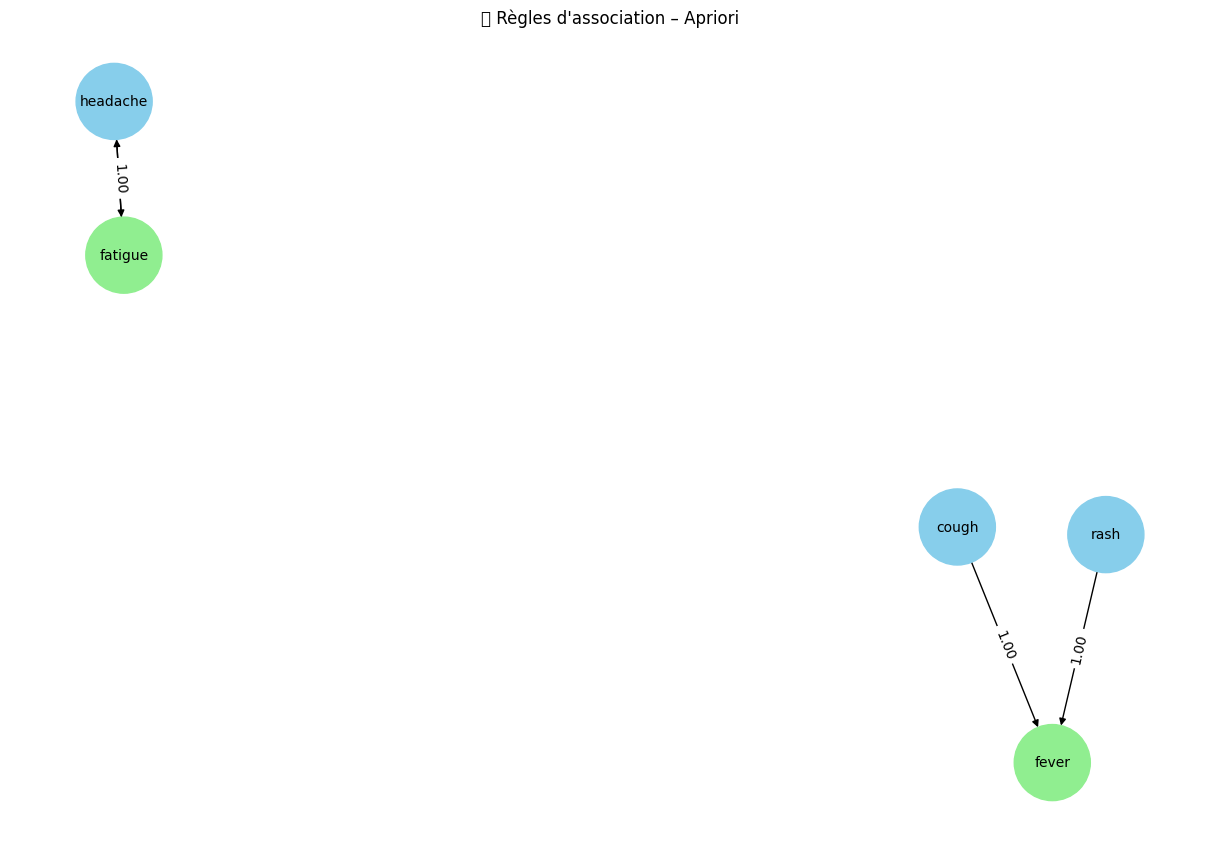

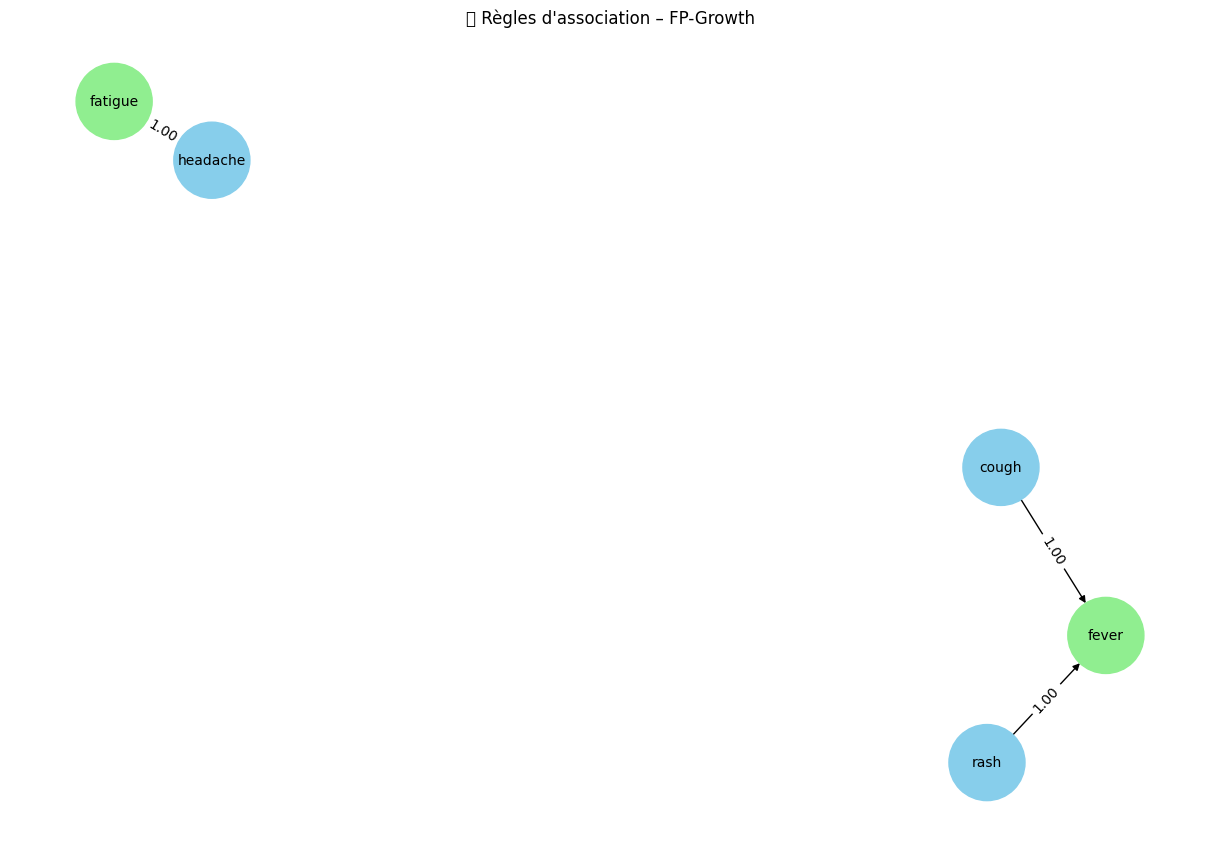

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_rules_graph(rules_df, algo_name, top=10):
    if rules_df.empty:
        print(f"⚠️ Aucune règle pour {algo_name}")
        return

    G = nx.DiGraph()

    # Prendre les top règles par confiance
    rules_df = rules_df.sort_values(by="confidence", ascending=False).head(top)

    for _, row in rules_df.iterrows():
        antecedents = ', '.join(list(row['antecedents']))
        consequents = ', '.join(list(row['consequents']))
        label = f"{row['confidence']:.2f}"

        G.add_node(antecedents, color='skyblue')
        G.add_node(consequents, color='lightgreen')
        G.add_edge(antecedents, consequents, weight=row['confidence'], label=label)

    # Couleurs des noeuds
    colors = [G.nodes[n]['color'] for n in G.nodes()]

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=3000, font_size=10, arrows=True)
    labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"🧠 Règles d'association – {algo_name}")
    plt.show()

# Générer les graphes
draw_rules_graph(results["Apriori"]["rules"], "Apriori")
draw_rules_graph(results["FP-Growth"]["rules"], "FP-Growth")


In [ ]:
import json
import pandas as pd # Ensure pandas is imported if it wasn't in the original cell

# Sauvegarde Apriori
rules_apriori = results["Apriori"]["rules"]

# Convert frozensets to lists before converting to dictionary
rules_apriori_list = []
for index, row in rules_apriori.iterrows():
    rule_dict = row.to_dict()
    rule_dict['antecedents'] = list(rule_dict['antecedents']) # Convert frozenset to list
    rule_dict['consequents'] = list(rule_dict['consequents']) # Convert frozenset to list
    rules_apriori_list.append(rule_dict)

with open("rules_apriori.json", "w") as f:
    json.dump(rules_apriori_list, f, indent=2)
print("✅ Règles Apriori sauvegardées dans rules_apriori.json")

# Sauvegarde FP-Growth
rules_fpgrowth = results["FP-Growth"]["rules"]

# Convert frozensets to lists before converting to dictionary
rules_fpgrowth_list = []
for index, row in rules_fpgrowth.iterrows():
    rule_dict = row.to_dict()
    rule_dict['antecedents'] = list(rule_dict['antecedents']) # Convert frozenset to list
    rule_dict['consequents'] = list(rule_dict['consequents']) # Convert frozenset to list
    rules_fpgrowth_list.append(rule_dict)

with open("rules_fpgrowth.json", "w") as f:
    json.dump(rules_fpgrowth_list, f, indent=2)
print("✅ Règles FP-Growth sauvegardées dans rules_fpgrowth.json")

✅ Règles Apriori sauvegardées dans rules_apriori.json
✅ Règles FP-Growth sauvegardées dans rules_fpgrowth.json


In [ ]:
!pip install flask-ngrok flask flask-cors


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from flask_ngrok import run_with_ngrok
import pandas as pd

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)  # Rend l'app accessible via une URL publique

rules = pd.read_json("rules_fpgrowth.json")

@app.route("/diagnose", methods=["POST"])
def diagnose():
    symptoms_input = request.json.get("symptoms", [])
    results = []

    for _, row in rules.iterrows():
        if set(row["antecedents"]).issubset(symptoms_input):
            results.append({
                "diagnosis": list(row["consequents"]),
                "confidence": round(row["confidence"], 2)
            })

    return jsonify(sorted(results, key=lambda x: x["confidence"], reverse=True))

app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


/usr/local/lib/python3.11/dist-packages/flask_ngrok.py:86: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  thread.setDaemon(True)
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most

In [ ]:
!wget -q -c https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
